# Simple YOLO model

Вся выжимка из анализа набора данных при помощи "пристального взгляда" описана в ```README.md```. Также там есть размышления по решению данной задачи через **эвристику**.

**ОБЯЗАТЕЛЬНО ПРОЧТИТЕ ```README.md```!!!**

## Задача
Определить количество книг на фотографии.

## Размышления
Первое, что мне пришло в голову исходя из глобальной задачи (решить проблему "Правила размещения на площадке") - это применить для этой задачи **детекторы**. Т.е. в дальнейшем хотим использовать данную модель/систему для разбиения одного размещения с несколькими книгами на несколько размещений по одной книге. 

Почему именно детекторы - потому что мы можем увидеть, что именно модель/система считает за книгу, также есть пул предобученных моделей. 

## Логика
1) Беру предобученную **YOLO** для детекции (Предобученный детектор можно брать любой, главное, чтобы в датасете, на котором он обучался, был класс "книга")
2) Прогоняем фото через детектор 
3) Ищем детекции с классом соответствющим книге
4) Считаем кол-во детекций (кол-во детекций = кол-ву книг на фото)

На данном этапе я пока **не буду** делать препроцессинг и постпроцессинг.

Буду считать данное решение **baseline**.

# Import

In [49]:
import os

while os.getcwd().split("/")[-1] != "book_counter":
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [50]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from utils.plot_images import plot_res_images_slice

# Input/Output Configuration 

In [51]:
images_folder = 'task_images'
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
image_files.sort(key=lambda x: int(x.split('.')[0]))

In [52]:
output_folder = 'detection_results_simple_yolo'

os.makedirs(output_folder, exist_ok=True)

In [53]:
solution_csv_path = "solution_simple_yolo.csv"

# Init model

In [54]:
model = YOLO('yolo11l.pt')
conf_threshold = 0.3

YOLO обучен на датасете COCO, класс "книга" есть в данном датасете и соответствует id = 73

# Inference (Object Detection and Counting)

In [55]:
submission_df = pd.DataFrame(columns=['image_id', 'number_of_books'])

In [ ]:
def count_books_simple_yolo(
    model: YOLO,
    img_path: str,
    conf_threshold: int = 0.5,
    output_dir: str = "detection_results_simple_yolo",
) -> int:
    """Подсчет кол-ва книг через детекцию моделью YOLO

    Args:
        model (YOLO): Модель YOLO
        img_path (str): Путь до изображения
        conf_threshold (int, optional): Порог уверенности в детекции. Defaults to 0.5
        output_dir (str): Директория для сохранения изображений с разметкой

    Returns:
        int: Кол-во книг на фото
    """
    image = cv2.imread(img_path)

    image_with_boxes = image.copy()
    book_count = 0

    # прогоняем изображение через детектор и берем только детекции, в которых уверенность модели больше conf_threshold
    results = model(image, conf=conf_threshold, verbose=False)

    for result in results:
        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy().astype(int)

            for box, conf, class_id in zip(boxes, confidences, class_ids):
                if class_id == 73:  # class_id для 'book' в датасете COCO
                    book_count += 1

                    # отрисовка bbox
                    x1, y1, x2, y2 = map(int, box)

                    cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    label = f"{conf:.2f}"
                    (text_width, text_height), _ = cv2.getTextSize(
                        label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2
                    )

                    cv2.rectangle(
                        image_with_boxes,
                        (x1, y1 - text_height - 5),
                        (x1 + text_width, y1),
                        (0, 255, 0),
                        -1,
                    )

                    cv2.putText(
                        image_with_boxes,
                        label,
                        (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 0, 0),
                        2,
                    )

    filename = os.path.splitext(os.path.basename(img_path))[0]
    output_path = os.path.join(output_dir, f"{filename}_result.jpg")
    cv2.imwrite(output_path, image_with_boxes)

    return book_count

In [57]:
# Обработка всех фото
for img_file in image_files:
    img_path = os.path.join(images_folder, img_file)

    # подсчет книг через YOLO
    book_count = count_books_simple_yolo(model, img_path, conf_threshold)

    submission_df = pd.concat(
        [
            submission_df,
            pd.DataFrame(
                {"image_id": [img_file.split(".")[0]], "number_of_books": [book_count]}
            ),
        ],
        ignore_index=True,
    )

In [58]:
submission_df.to_csv(
    solution_csv_path, header=["image_id", "number_of_books"], index=False
)

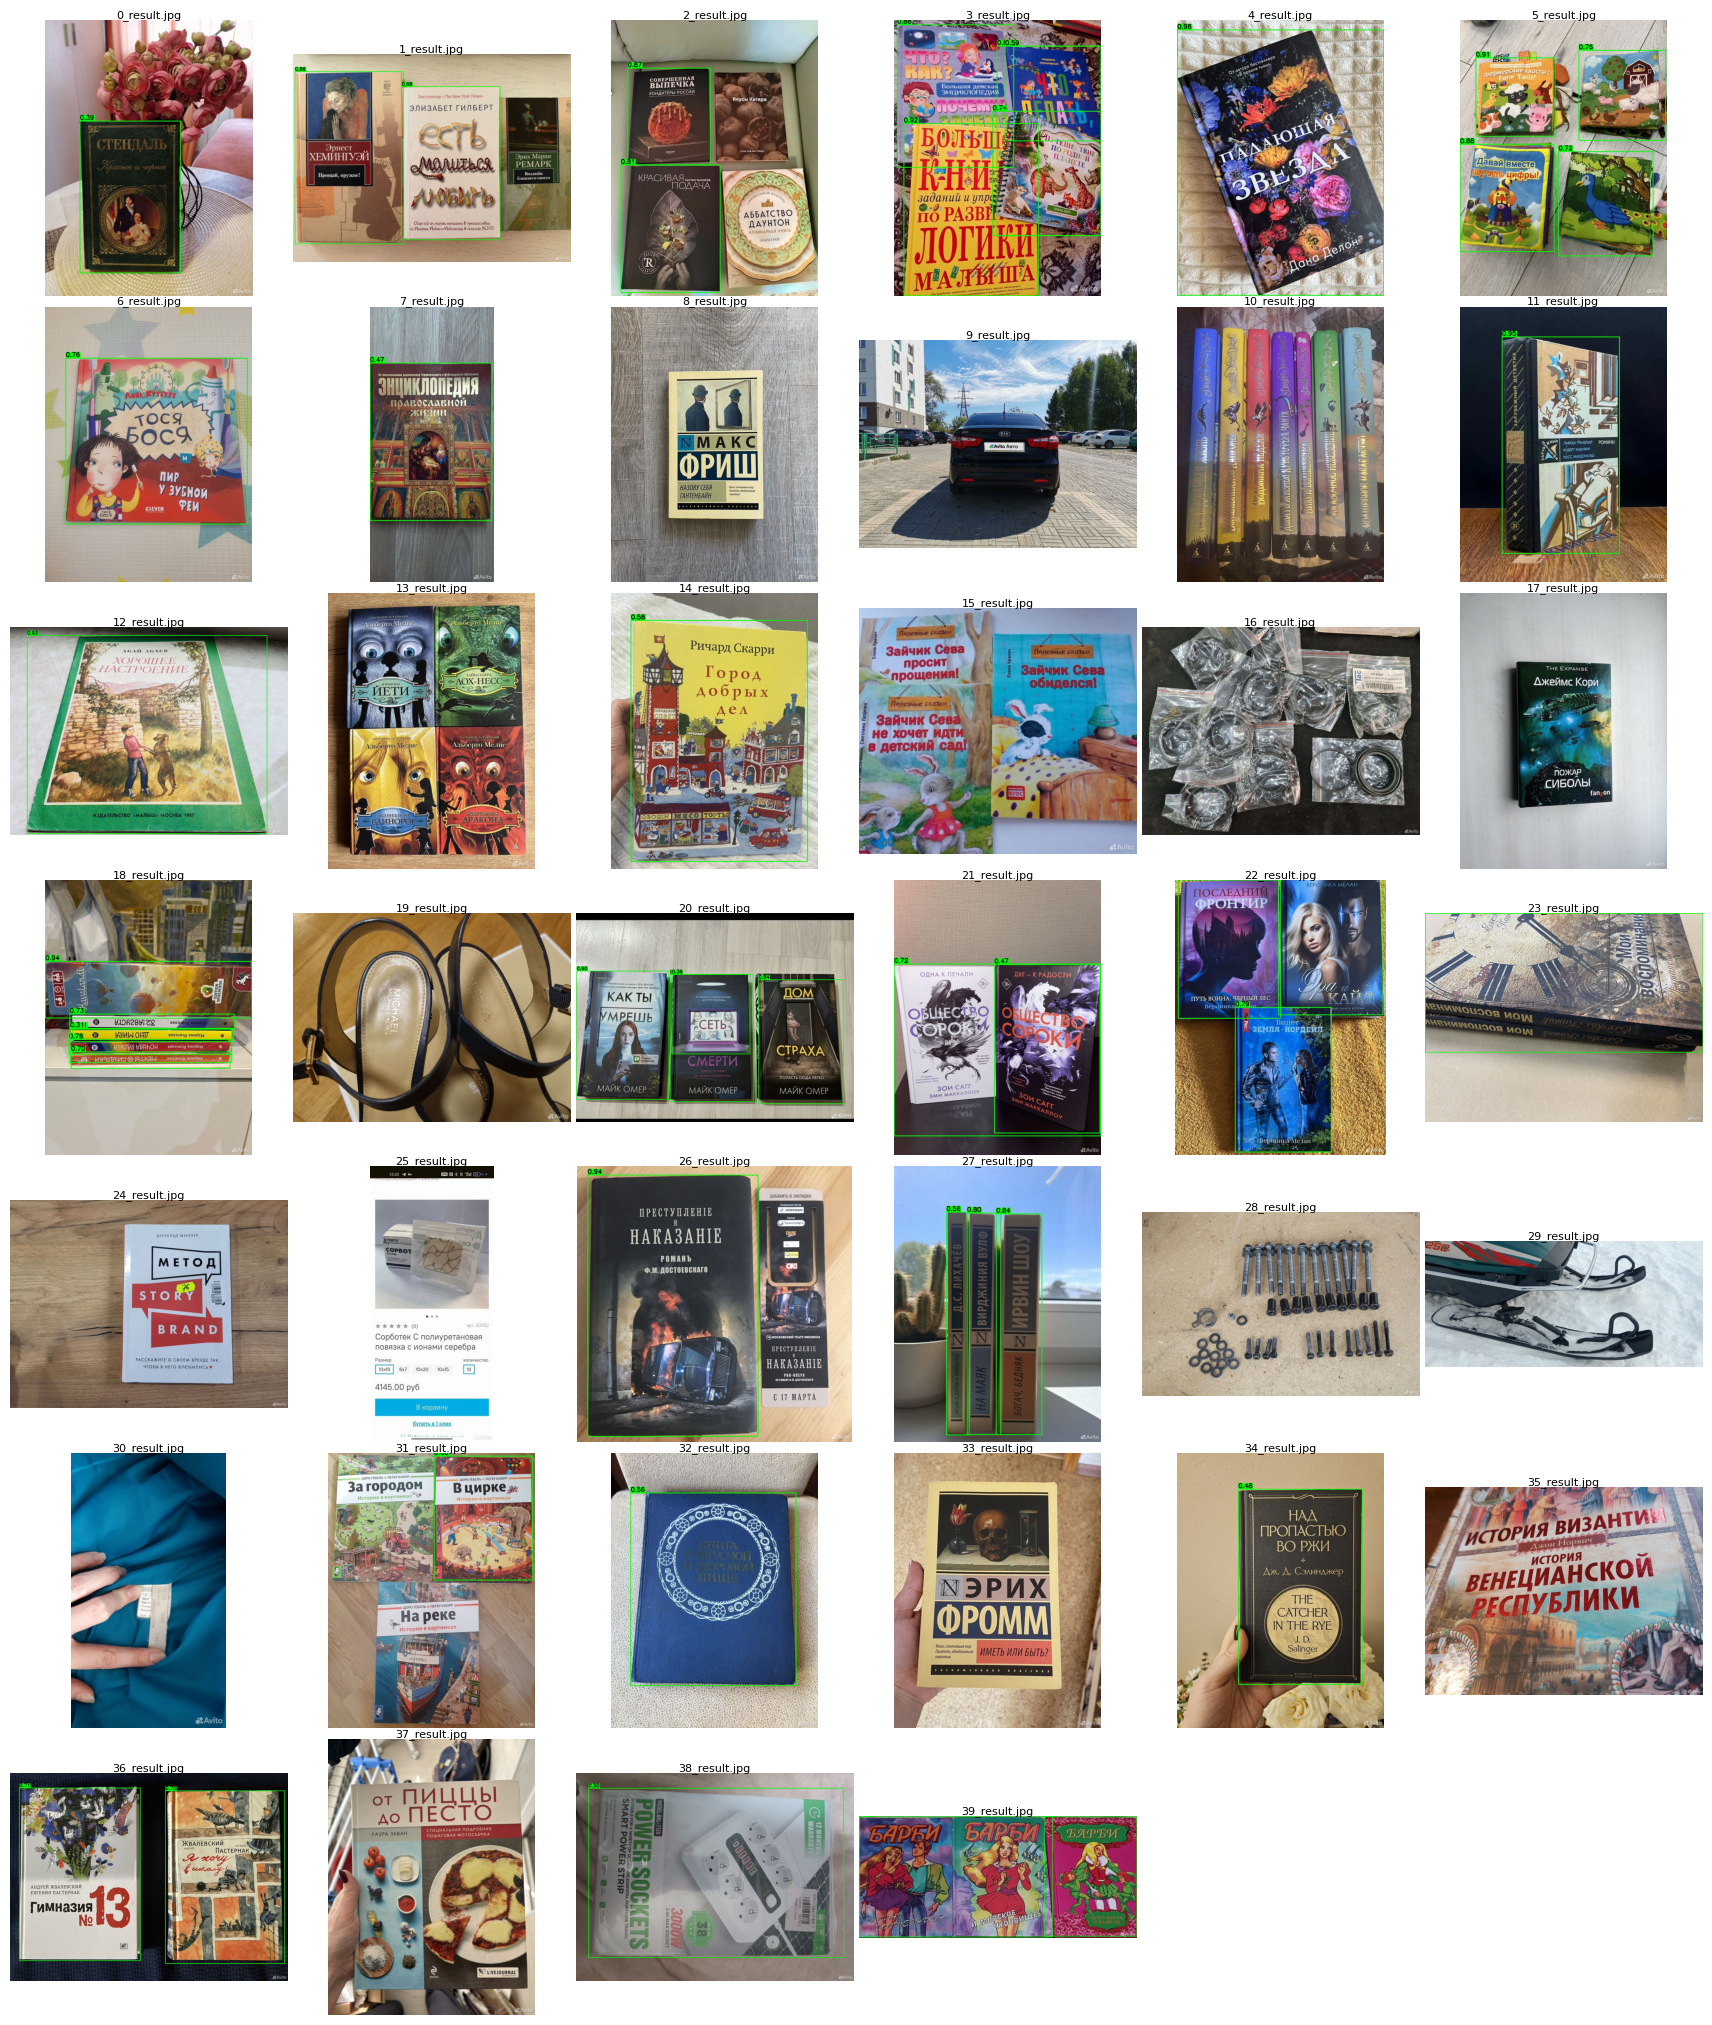

In [59]:
plot_res_images_slice(output_folder, start=0, end=40, max_cols=6)

## Пример работы

Есть неплохие примеры работы, но они все равно не находят все книги.

![good_simple_yolo_ex](../imgs/good_simple_yolo_ex.jpg)

Даже на довольно простых фото ему не всегда удается найти книги

![bad_simple_yolo_ex](../imgs/bad_simple_yolo_ex.jpg)

## Плюсы Simple YOLO model
- Небольшие вычислительные затраты
- Не требует обучения
- Меньше зависит от положения книги в кадре

## Минусы Simple YOLO model
- Недостаточная точность

## Проблемы данного решения

- Видно, что модель не справляется с ситуациями когда книги лежат **плотно друг к другу**

![books_tightly_packed](../task_images/13.jpg)

- Даже в некоторых **простых сценах** детектор не находит книги

![simple_ex](../task_images/17.jpg)

- Она не решает проблему, когда все фото это и есть обложка книги, т.е. **нет фона**

![img_wo_background](../task_images/181.jpg)

- Она не решает проблему, когда книга может быть **не полностью видна** на фото

![book_not_fully_visible](../task_images/70.jpg)